In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#1. Install Dependencies

In [ ]:
print("📦 Installing dependencies...")

!pip install -q sentence-transformers pandas numpy scikit-learn PyPDF2 python-docx openpyxl

print("✅ Dependencies installed!")


📦 Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 16.1 MB/s eta 0:00:00
✅ Dependencies installed!


#2. Imports

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
import re
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported!")


✅ Libraries imported!


#3. Load Model

In [ ]:
print("🤖 Loading Sentence-BERT model...")

model = SentenceTransformer('all-MiniLM-L6-v2')

print("✅ Model loaded successfully!")
print(f"📊 Model embedding dimension: {model.get_sentence_embedding_dimension()}")

🤖 Loading Sentence-BERT model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Model loaded successfully!
📊 Model embedding dimension: 384


#4. Data Process

In [ ]:
def clean_text(text):
    """Clean and normalize text"""
    if not isinstance(text, str):
        return ""

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters but keep spaces
    text = re.sub(r'[^a-zA-Z0-9\s\.\,]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text.strip()


def extract_skills(text):
    skill_keywords = [
        'python', 'java', 'javascript', 'c++', 'sql', 'machine learning',
        'deep learning', 'nlp', 'bert', 'deberta', 'transformers',
        'pytorch', 'tensorflow', 'react', 'angular', 'nodejs',
        'django', 'flask', 'aws', 'gcp', 'azure', 'docker', 'kubernetes',
        'git', 'agile', 'scrum', 'data analysis', 'excel'
    ]

    text_lower = text.lower()
    found_skills = []
    for skill in skill_keywords:
        # Use word boundaries to avoid partial matches
        if re.search(rf'\b{re.escape(skill)}\b', text_lower):
            found_skills.append(skill)
    return found_skills

print("✅ Preprocessing functions ready!")

✅ Preprocessing functions ready!


#5. Job Description

In [ ]:
# Sample job description
job_description = """
Senior Data Scientist - FinTech
Location: London, UK (Hybrid)

We are looking for an experienced Data Scientist to join our AI team. You will be responsible for developing machine learning models for fraud detection, customer segmentation, and predictive analytics.

Responsibilities:
- Design, build, and deploy machine learning models in production
- Perform statistical analysis and A/B testing
- Collaborate with engineering teams to implement data pipelines
- Communicate insights to stakeholders

Requirements:
- 3+ years experience in data science
- Strong Python skills (pandas, scikit-learn, PyTorch/TensorFlow)
- Experience with SQL and big data technologies
- Knowledge of statistical modeling and machine learning
- MSc/PhD in Computer Science, Statistics, or related field

Nice to have:
- Experience in financial services
- Knowledge of cloud platforms (AWS, GCP)
- Experience with Docker and MLOps

"""
print(f"📋 Job Description length: {len(job_description)} characters")


# Clean and embed job description
jd_clean = clean_text(job_description)
jd_embedding = model.encode(jd_clean, convert_to_tensor=False)



print(f"📊 JD embedding shape: {jd_embedding.shape}")



📋 Job Description length: 915 characters
📊 JD embedding shape: (384,)


#6. Data Load from Kaggle

In [ ]:
## ....download dataset....##

import kagglehub

# Download latest version
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")

print("Path to dataset files:", path)

##......Save Dataset in MyDrive to use later...

!cp -r "/root/.cache/kagglehub/datasets/snehaanbhawal/resume-dataset" "/content/drive/MyDrive/"




Using Colab cache for faster access to the 'resume-dataset' dataset.
Path to dataset files: /kaggle/input/resume-dataset


#7. Kaggle  Data Check

In [ ]:
##....Load data and check properties ....

data_path = "/content/drive/MyDrive/resume-dataset/versions/1/Resume/Resume.csv"
df = pd.read_csv(data_path)
print(df.head())
print(df.columns)
# All unique categories
print(df['Category'].unique())

# Number of unique categories
print("Number of distinct categories:", df['Category'].nunique())


         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  
Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')
['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' 'TEACHER' 'ADVOCATE'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES'
 'CONSULTA

#8: Tech Resume Embedding

In [ ]:
batch_size = 50
tech_resume_embeddings = []

# Filter technical resumes
tech_resumes = df[df['Category'].isin(['INFORMATION-TECHNOLOGY', 'ENGINEERING'])]
print("Total resumes:", len(tech_resumes))

# Generate embeddings in batches
for i in range(0, len(tech_resumes), batch_size):
    batch = tech_resumes.iloc[i:i+batch_size]  # slice by index

    clean_batch = [clean_text(r) for r in batch['Resume_str']]
    batch_emb = model.encode(clean_batch, convert_to_tensor=False)

    tech_resume_embeddings.extend(batch_emb)
    print(f"Processed {i+len(batch)} / {len(tech_resumes)}")

##....Save Embedding .....

tech_resume_embeddings = np.array(tech_resume_embeddings)
np.save('/content/tech_resume_embeddings.npy', tech_resume_embeddings)


Total resumes: 238
Processed 50 / 238
Processed 100 / 238
Processed 150 / 238
Processed 200 / 238
Processed 238 / 238


#9 Calculate Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

tech_resume_embeddings = np.load('/content/tech_resume_embeddings.npy')

# Cosine similarity
similarities = cosine_similarity([jd_embedding], tech_resume_embeddings)[0]

# Ranking
results = []
for i, score in enumerate(similarities):
    results.append({
        'ID': tech_resumes.iloc[i]['ID'],
        'Category': tech_resumes.iloc[i]['Category'],
        'Similarity Score': round(score, 4),
        'Percentage Match': round(score*100, 2)
    })

results_df = pd.DataFrame(results).sort_values('Similarity Score', ascending=False)
results_df['Rank'] = range(1, len(results_df)+1)
print(results_df.head())


           ID                Category  Similarity Score  Percentage Match  \
192  12011623             ENGINEERING            0.5972         59.720001   
64   37242217  INFORMATION-TECHNOLOGY            0.5427         54.270000   
204  22605864             ENGINEERING            0.5304         53.040001   
80   83816738  INFORMATION-TECHNOLOGY            0.5083         50.830002   
50   13405733  INFORMATION-TECHNOLOGY            0.4943         49.430000   

     Rank  
192     1  
64      2  
204     3  
80      4  
50      5  


#10: Detail analysis of Candidate

In [ ]:
print("\n" + "="*70)
print("🔍 DETAILED ANALYSIS - TOP CANDIDATE")
print("="*70)

top_candidate_id = results_df.iloc[0]['ID']
top_candidate = tech_resumes[tech_resumes['ID'] == top_candidate_id].iloc[0]

print(f"\n👤 Candidate ID: {top_candidate['ID']}")
print(f"⭐ Match Score: {results_df.iloc[0]['Percentage Match']}%")
print(f"\n📄 Resume Preview:")
print(top_candidate['Resume_str'][:300] + "...")

jd_skills = extract_skills(job_description)
resume_skills = extract_skills(top_candidate['Resume_str'])

matching_skills = set(jd_skills) & set(resume_skills)
missing_skills = set(jd_skills) - set(resume_skills)

print(f"\n✅ Matching Skills ({len(matching_skills)}):")
print(", ".join(sorted(matching_skills)) if matching_skills else "None detected")

print(f"\n❌ Missing Skills ({len(missing_skills)}):")
print(", ".join(sorted(missing_skills)) if missing_skills else "None")

print("="*70)



🔍 DETAILED ANALYSIS - TOP CANDIDATE

👤 Candidate ID: 12011623
⭐ Match Score: 59.720001220703125%

📄 Resume Preview:
         ENGINEERING AND QUALITY TECHNICIAN       Career Overview    A highly experienced skilled graduate with Analytics degree with a very good experience in SAS, Web scraping, SQL, Predictive modelling and data visualization. Excellent ability in identifying data requirements for analysis, data c...

✅ Matching Skills (3):
machine learning, python, sql

❌ Missing Skills (5):
aws, docker, gcp, pytorch, tensorflow


#11: Visiualisation

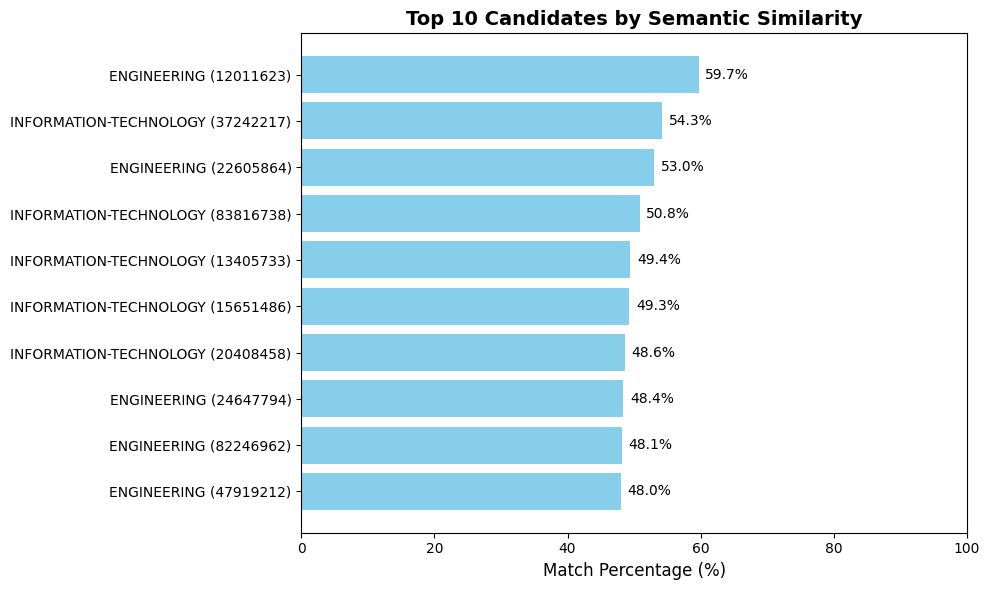

In [ ]:
import matplotlib.pyplot as plt

top_n = 10
top_df = results_df.head(top_n)

labels = top_df['Category'] + " (" + top_df['ID'].astype(str) + ")"


plt.figure(figsize=(10, 6))
plt.barh(labels, top_df['Percentage Match'], color='skyblue')
plt.xlabel('Match Percentage (%)', fontsize=12)
plt.title(f'Top {top_n} Candidates by Semantic Similarity', fontsize=14, fontweight='bold')
plt.xlim(0, 100)

# Add value labels
for i, score in enumerate(top_df['Percentage Match']):
    plt.text(score + 1, i, f'{score:.1f}%', va='center', fontsize=10)

plt.gca().invert_yaxis()  # Highest score on top
plt.tight_layout()
plt.show()
